# Gnomix Demo


### Loading packages

In [1]:
import numpy as np
import os
import pandas as pd
#importing module (only for jupytercluster)
exec(open("/shared/software/modules/4.6.1/init/python.py").read(), globals())
module("load", "bcftools")

python='/shared/projects/machinelearning_popgen/conda/envs/TER/bin/python3'
print("bcftools has been loaded")

bcftools has been loaded


In [3]:
# Arguments
data_path="../data/input/real/"
query_file = data_path+ "5pop_250query.vcf.gz"
genetic_map_file = "allchrs_b37.gmap"
genetic_map_path=genetic_map_file
reference_file   = data_path + "5pop_1500sample.vcf.gz"
sample_map_file  = data_path + "5pop_1500sample.smap"
chm              = "1"
phase            = "False"
output_basename  = "../data/output_gnomix/1500samples_250query/"

if (os.path.isdir(output_basename)==False):
    os.mkdir(output_basename)
    print('Creating directory')

Creating directory


## Training a model from scratch

Here we use the command line interface to train a model using a reference file, make inference on a query file and then write the results to the file *demo.msp.txv*. 

In [ ]:
train_cmd = " ".join([python,"./gnomix.py",
                      query_file, output_basename,chm, phase, genetic_map_file, reference_file, sample_map_file]) + \
            " > ../data/output_gnomix/training_log.txt"
print("Running in command line: \n\t", train_cmd)
os.system(train_cmd)

Running in command line: 
	 /shared/projects/machinelearning_popgen/conda/envs/TER/bin/python3 ./gnomix.py ../data/input/real/5pop_250query.vcf.gz ../data/output_gnomix/1500samples_250query/ 1 False allchrs_b37.gmap ../data/input/real/5pop_1500sample.vcf.gz ../data/input/real/5pop_1500sample.smap > ../data/output_gnomix/training_log.txt


100%|████████████████████████████████████████| 1427/1427 [02:18<00:00, 10.33it/s]


## Analyzing results

### Reading from the ouput

Here we read the results from the output file into a dataframe

In [4]:
# read the output file into a dataframe
output_file = output_basename+"/query_results.msp"
msp_df = pd.read_csv(output_file, sep="\t", skiprows=[0])
msp_df

,#chm,spos,epos,sgpos,egpos,n snps,NA19393.0,NA19393.1,HG02322.0,HG02322.1,...,HG01073.0,HG01073.1,HG01951.0,HG01951.1,HG01305.0,HG01305.1,HG00142.0,HG00142.1,HG01372.0,HG01372.1
0,1,534247,893981,1.37632,2.41971,123,3,3,3,3,...,0,0,4,4,4,4,0,0,4,4
1,1,894573,985460,2.42133,2.61148,123,3,3,3,3,...,0,0,4,4,4,4,0,0,4,4
2,1,985826,1106684,2.61167,2.81075,123,3,3,3,3,...,0,0,4,4,4,4,0,0,4,4
3,1,1106784,1206343,2.81179,2.97442,123,3,3,3,3,...,0,0,4,4,4,4,0,0,0,4
4,1,1206619,1415012,2.97465,3.17658,123,3,3,3,3,...,0,0,4,4,4,4,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,1,248028219,248129173,285.07322,285.21266,123,3,3,3,3,...,4,4,4,4,3,4,0,0,4,4
1423,1,248129195,248302707,285.21269,285.41225,123,3,3,3,3,...,4,4,4,4,3,4,0,0,4,4
1424,1,248304895,248498027,285.41277,285.57927,123,3,3,3,3,...,4,4,4,4,3,4,0,0,4,4
1425,1,248507806,248687952,285.58777,285.86516,123,3,3,3,3,...,4,4,4,4,3,4,0,0,4,4


## Measuring performance

In [5]:
from scipy import stats
from sklearn.metrics import confusion_matrix

from src.postprocess import get_samples_from_msp_df
from src.visualization import plot_cm, plot_chm

%load_ext autoreload
%autoreload 2

Here we predict **single ancestry** for each individual by creatoing a dataframe containing only one label prediction for each individual. We do so simply by taking the mode of the local predictions for each individual. 

In [6]:
# reading the sample-ids
query_samples = get_samples_from_msp_df(msp_df)

# reading predictions for each of the intervals
pred_labels = (np.array(msp_df)[:,6:].T).astype(int)

# reducing it to only 1 of maternal/paternal prediction
single_ind_idx = np.arange(0,len(query_samples)*2,2)
pred_labels_single_ind = pred_labels[single_ind_idx,:]

# predicting single ancestry by taking mode of local predictions for each individual
y_pred = stats.mode(pred_labels_single_ind,axis=1)[0].squeeze() 

# get model population order from first line of file and convert from numeric predictions
with open(output_file, "r") as f:
    pop = np.array([p.split("=")[0] for p in f.readline().split()[2:]])
pred_pop = [pop[pop_ind] for pop_ind in y_pred]

# put it together in dataframe
pred_df = pd.DataFrame({"Sample": query_samples, "Prediction": pred_pop})
pred_df

,Sample,Prediction
0,NA19393,AFR
1,HG02322,AFR
2,HG01958,AFR
3,HG02332,AFR
4,HG02317,AFR
5,HG03372,AFR
6,HG02675,AFR
7,HG02337,AFR
8,HG02464,AFR
9,NA18881,AFR


We can read the true labels from the sample map file and add them to the dataframe. The true ancestry labels (not only single ancestry individuals) are stored in the meta data file *demo/data/1000g.meta*.

In [11]:
# adding the true labels
all_sample_map_file=data_path + 'all_sample.smap'
all_sample_map_df = pd.read_csv(all_sample_map_file, sep="\t",skiprows=[0])
all_sample_map_df.columns = ['Sample', 'Superpopulation code']
true_labels_df = all_sample_map_df[["Sample", "Superpopulation code"]]
true_labels_df.columns = ["Sample", "Population"]
pred_df = pred_df.merge(true_labels_df)
print(pred_df)

     Sample Prediction Population
0   NA19393        AFR        AFR
1   HG02322        AFR        AFR
2   HG01958        AFR        AFR
3   HG02332        AFR        AFR
4   HG02317        AFR        AFR
5   HG03372        AFR        AFR
6   HG02675        AFR        AFR
7   HG02337        AFR        AFR
8   HG02464        AFR        AFR
9   NA18881        AFR        AFR
10  HG00628        EAS        EAS
11  NA18964        EAS        EAS
12  HG02395        EAS        EAS
13  HG02356        EAS        EAS
14  HG01862        EAS        EAS
15  NA18962        EAS        EAS
16  HG01853        EAS        EAS
17  HG03856        SAS        SAS
18  NA18989        EAS        EAS
19  HG03694        SAS        SAS
20  NA20906        SAS        SAS
21  NA18602        EAS        EAS
22  NA19002        EAS        EAS
23  HG01624        EUR        EUR
24  HG03999        SAS        SAS
25  HG03713        SAS        SAS
26  HG03911        SAS        SAS
27  HG00345        EUR        EUR
28  HG03977   

And then compare the predictions with the true labels

In [14]:
# Getting the prediction accuracy
acc = np.mean(pred_df.Population == pred_df.Prediction)
print("Accuracy for single ancestry: ", acc*100, "%", sep="")

Accuracy for single ancestry: 98.0%


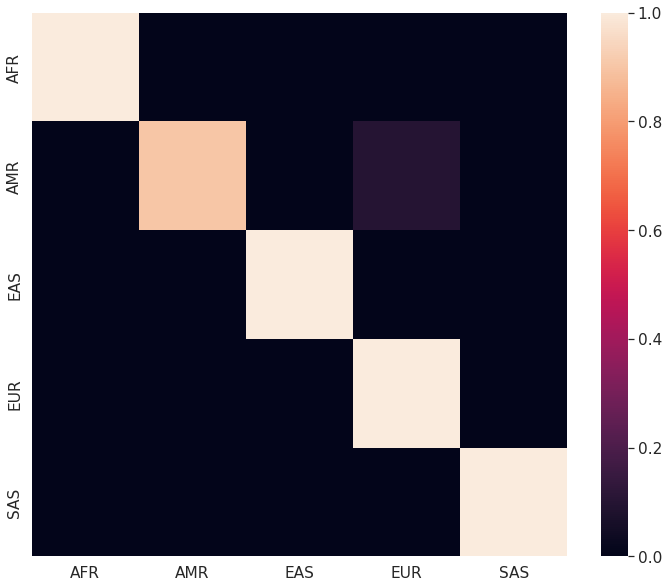

In [23]:
# creating and visualizing the confusion matrix
labs = np.unique(pred_df[['Population', 'Prediction']])
cm = confusion_matrix(pred_df.Population, pred_df.Prediction, labels=labs)
cm_plot = plot_cm(cm, normalize=True, labels=labs)
#cm_plot.figure.savefig('..data/output_gnomix/single_ancestry_confusion_matrix.png')

## Plotting the prediction


tagore --i ./tagore.tsv -p ../data/output_gnomix/chm_img --build hg37 -f


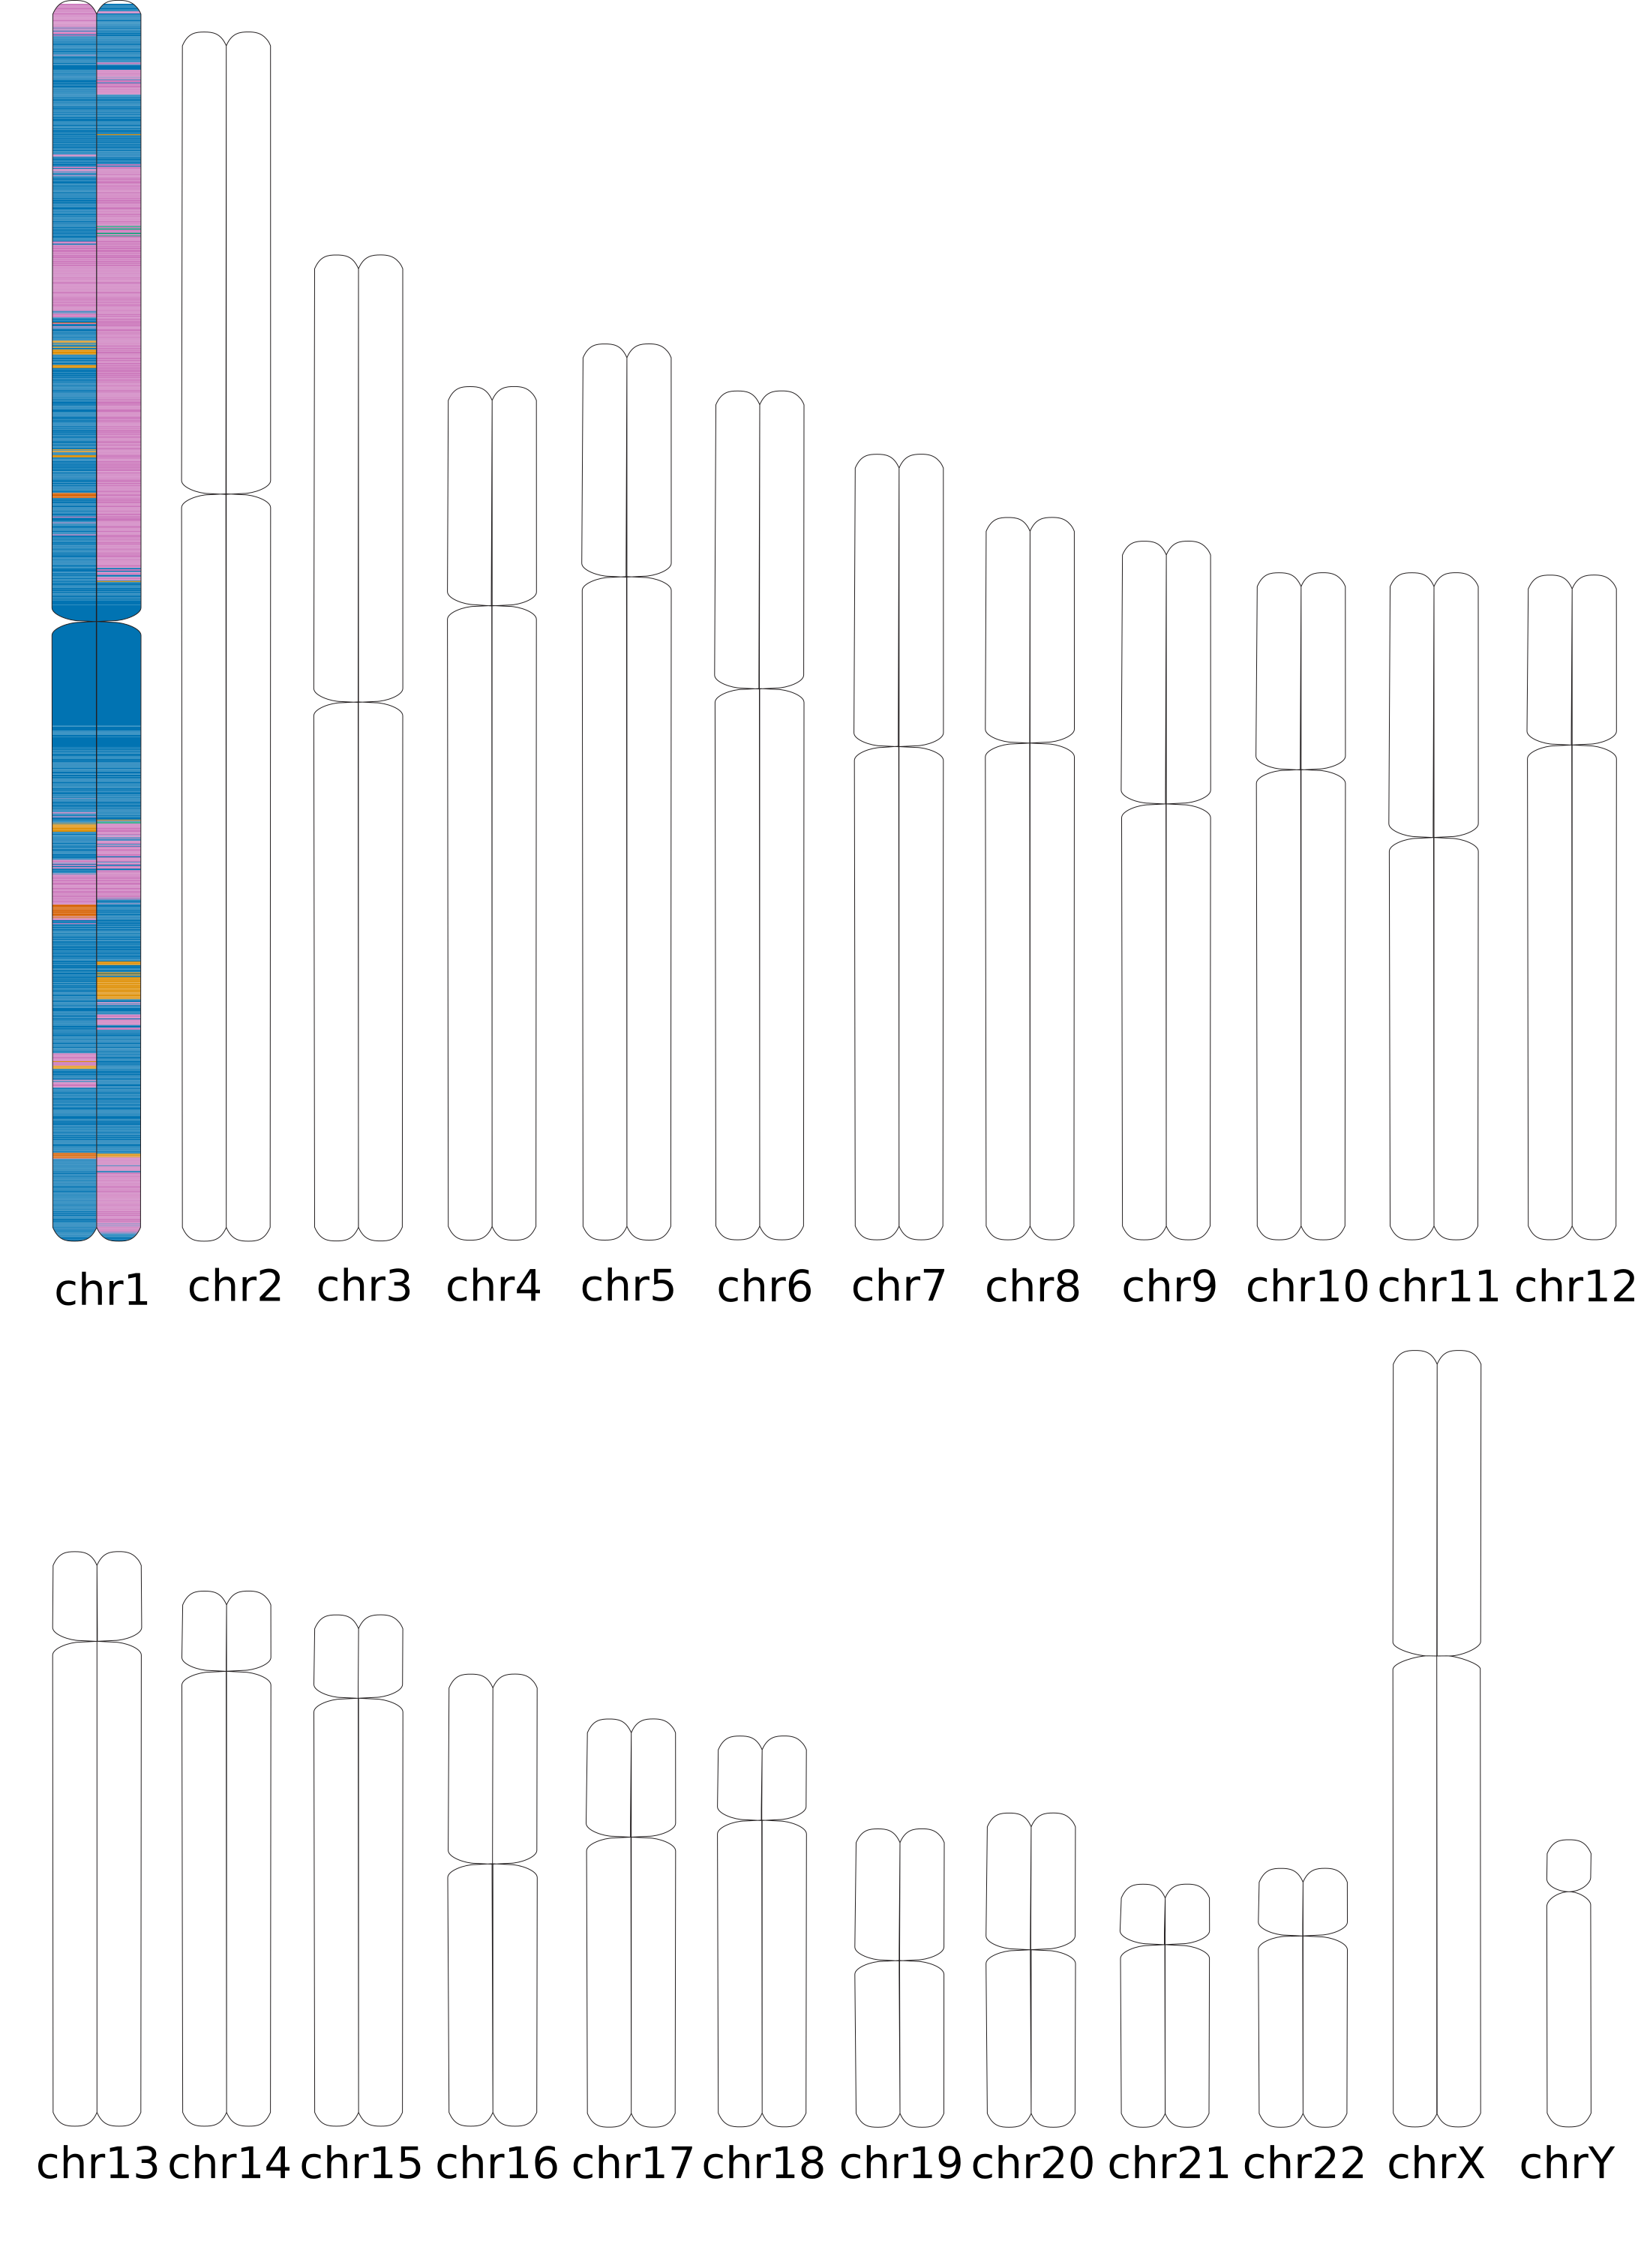

In [29]:
from IPython.display import Image

sample_id = "HG01122" # looking at just one random sample
img_name = "../data/output_gnomix/chm_img"
plot_chm(sample_id, msp_df, img_name=img_name)
Image(filename=img_name+".png")